# Defining MLP

In [35]:
# import os
# os.chdir('/Users/mikolajmroz/Developer/Computational_Intelligence_Methods')
# print(os.getcwd())

In [36]:
import os
os.chdir('c:\\Users\\mikol\\Documents\\Computational_Intelligence_Methods\\Computational_Intelligence_Methods')
print(os.getcwd())

c:\Users\mikol\Documents\Computational_Intelligence_Methods\Computational_Intelligence_Methods


In [37]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score

In [38]:
def linear(x):
    """Linear activation function: f(x) = x"""
    return x

In [39]:
def linear_derivative(x):
    """Derivative of linear activation function: f'(x) = 1"""
    return 1

In [40]:
def relu(x):
    return np.maximum(0, x)

In [41]:
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

In [42]:
def sigmoid(x):
    x = np.clip(x, -500, 500)  # Avoid overflow
    return np.where(x > 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

In [43]:
def sigmoid_derivative(sigmoid_output):
    # Assumes that sigmoid_output is the result of sigmoid(x)
    return sigmoid_output * (1 - sigmoid_output)

In [44]:
def tanh(x):
    """Tanh activation function: f(x) = tanh(x)"""
    return np.tanh(x)

In [45]:
def tanh_derivative(x):
    """Derivative of tanh activation function: f'(x) = 1 - tanh(x)^2"""
    return 1 - np.tanh(x)**2

In [46]:
def mse(predictions, targets):
    return np.mean((predictions - targets) ** 2)

In [47]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
    return exp_x / exp_x.sum(axis=0, keepdims=True)

In [48]:
def cross_entropy(softmax_output, y_true):
    # Assuming y_true is one-hot encoded
    m = y_true.shape[1]  # Number of examples
    log_likelihood = -np.log(softmax_output[y_true.argmax(axis=0), range(m)] + 1e-9)  # Small constant added
    loss = np.sum(log_likelihood) / m
    return loss

In [49]:
def cross_entropy_derivative(softmax_output, y_true):

    corrected_softmax_output = softmax_output - y_true
    
    return corrected_softmax_output
        


In [50]:
def softmax_derivative(softmax_output):
    # For softmax combined with cross-entropy loss, the derivative simplifies
    # the gradient calculation in backpropagation, directly using output error.
    return softmax_output

In [51]:
class MLP:
    def __init__(self, sizes, activation_fn=sigmoid, activation_fn_derivative=sigmoid_derivative):
        self.layer_sizes = sizes
        self.activation_fn = activation_fn
        self.activation_fn_derivative = activation_fn_derivative
        self.layer_weights = [np.random.randn(y, x) * np.sqrt(2. / x) / 10 for x, y in zip(sizes[:-1], sizes[1:])]
        self.layer_biases = [np.zeros((y, 1)) for y in sizes[1:]]

    def display_weights_biases(self):
        print("Final Weights and Biases:")
        for layer_index, (weights, biases) in enumerate(zip(self.layer_weights, self.layer_biases)):
            print(f"Layer {layer_index + 1} Weights:\n{weights}")
            print(f"Layer {layer_index + 1} Biases:\n{biases}")

    def propagate_forward(self, input_activation):
        activations = [input_activation]
        for biases, weights in zip(self.layer_biases, self.layer_weights[:-1]):
            input_activation = self.activation_fn(np.dot(weights, input_activation) + biases)
            activations.append(input_activation)
        final_input = np.dot(self.layer_weights[-1], input_activation) + self.layer_biases[-1]
        output_activation = softmax(final_input)
        activations.append(output_activation)
        return output_activation, activations

    def backward_propagation(self, input_val, true_val):
        weight_gradients = [np.zeros(weight.shape) for weight in self.layer_weights]
        bias_gradients = [np.zeros(bias.shape) for bias in self.layer_biases]
        
        # Forward pass to get activations
        final_act, activations = self.propagate_forward(input_val)
        
        # Start with the derivative of the loss function w.r.t. the final activation
        error = cross_entropy_derivative(final_act, true_val)
        
        # Update gradients for the output layer
        bias_gradients[-1] = error
        weight_gradients[-1] = np.dot(error, activations[-2].T)
        
        # Backpropagate the error
        for l in range(2, len(self.layer_sizes)):
            activation_derivative = self.activation_fn_derivative(activations[-l])
            error = np.dot(self.layer_weights[-l+1].T, error) * activation_derivative
            
            bias_gradients[-l] = error
            weight_gradients[-l] = np.dot(error, activations[-l-1].T)
        
        return weight_gradients, bias_gradients

    
    def update_batch(self, batch, learn_rate, regularization, total_size, optimization_method, beta, epsilon=1e-8):
        gradient_w = [np.zeros(weight.shape) for weight in self.layer_weights]
        gradient_b = [np.zeros(bias.shape) for bias in self.layer_biases]
        
        for input_val, true_val in batch:
            delta_gradient_w, delta_gradient_b = self.backward_propagation(input_val, true_val)
            gradient_w = [w + dw for w, dw in zip(gradient_w, delta_gradient_w)]
            gradient_b = [b + db for b, db in zip(gradient_b, delta_gradient_b)]

        # Update rule for weights and biases based on the optimization method
        if optimization_method == 'momentum':
            # Momentum initialization
            if not hasattr(self, 'velocity_weights'):
                self.velocity_weights = [np.zeros_like(w) for w in self.layer_weights]
                self.velocity_biases = [np.zeros_like(b) for b in self.layer_biases]

            # Update velocities
            self.velocity_weights = [beta * vw + (1 - beta) * gw / len(batch) for vw, gw in zip(self.velocity_weights, gradient_w)]
            self.velocity_biases = [beta * vb + (1 - beta) * gb / len(batch) for vb, gb in zip(self.velocity_biases, gradient_b)]
            
            # Update weights and biases
            self.layer_weights = [(1 - learn_rate * (regularization / total_size)) * w - learn_rate * vw
                                  for w, vw in zip(self.layer_weights, self.velocity_weights)]
            self.layer_biases = [b - learn_rate * vb for b, vb in zip(self.layer_biases, self.velocity_biases)]
        elif optimization_method == 'rmsprop':
            # RMSprop initialization
            if not hasattr(self, 'squared_gradients_weights'):
                self.squared_gradients_weights = [np.zeros_like(w) for w in self.layer_weights]
                self.squared_gradients_biases = [np.zeros_like(b) for b in self.layer_biases]

            # Update squared gradients
            self.squared_gradients_weights = [beta * sgw + (1 - beta) * (gw**2) / len(batch)
                                              for sgw, gw in zip(self.squared_gradients_weights, gradient_w)]
            self.squared_gradients_biases = [beta * sgb + (1 - beta) * (gb**2) / len(batch)
                                             for sgb, gb in zip(self.squared_gradients_biases, gradient_b)]
            
            # Update weights and biases
            self.layer_weights = [(1 - learn_rate * (regularization / total_size)) * w - 
                                  learn_rate * gw / (np.sqrt(sgw) + epsilon)
                                  for w, sgw, gw in zip(self.layer_weights, self.squared_gradients_weights, gradient_w)]
            self.layer_biases = [b - learn_rate * gb / (np.sqrt(sgb) + epsilon)
                                 for b, sgb, gb in zip(self.layer_biases, self.squared_gradients_biases, gradient_b)]

    def train(self, training_data, epochs, learn_rate, batch_size, regularization=0.0, optimization_method='rmsprop', beta=0.9, epsilon=1e-8, visual_interval=10, X_val=None, y_val=None, target = None,adaptive_learn_rate = True, decay_rate=0.1, decay_step=100):
        n = len(training_data)

        f1_history = []
        
        # Determine mini-batch size based on whether the batch_size_input is a percentage or fixed value
        if isinstance(batch_size, float):  # If batch_size_input is a float, treat it as a percentage
            batch_size = max(1, min(n, int(n * batch_size / 100)))
        elif isinstance(batch_size, int):  # If batch_size_input is an integer, treat it as a fixed size
            batch_size = max(1, min(n, batch_size))
        else:  # Raise an error if batch_size_input is neither float nor int
            raise ValueError("batch_size_input must be an integer (fixed size) or a float (percentage of dataset)")
        
        
        for epoch in range(epochs):
            np.random.shuffle(training_data)
            mini_batches = [training_data[k:k + batch_size] for k in range(0, n, batch_size)]
    
            for mini_batch in mini_batches:
                self.update_batch(mini_batch, learn_rate, regularization, n, optimization_method, beta, epsilon)
            if adaptive_learn_rate:
                # Decay the learning rate every decay_step epochs
                if epoch % decay_step == 0 and epoch > 0:
                    learn_rate *= (1. / (1. + decay_rate * epoch))
    
            if epoch % visual_interval == 0:
                predictions = np.argmax(np.array([self.propagate_forward(x.reshape(-1, 1))[0] for x in X_val]), axis=1)
                accuracy = np.mean(predictions == y_val)
                print(f'epoch: {epoch}', f'Test accuracy: {accuracy}')
                
                f1_weighted = f1_score(y_val, predictions, average='weighted')
                f1_history.append((epoch,f1_weighted))
                print(f"F1 Score (Weighted): {f1_weighted}")
                
                if f1_weighted > target:
                    break
        return f1_history

    def visualize_network(self):
        fig, ax = plt.subplots()
    
        # For each layer
        for i in range(len(self.layer_sizes)):
            # Draw the nodes of the layer
            ax.scatter([i]*self.layer_sizes[i], range(self.layer_sizes[i]))
    
            # Draw the weights connecting the nodes of the current layer to the next layer
            if i < len(self.layer_sizes) - 1:
                for j in range(self.layer_sizes[i]):
                    for k in range(self.layer_sizes[i+1]):
                        weight = self.layer_weights[i][k, j]
                        color = 'g' if weight >= 0 else 'r'
                        ax.plot([i, i+1], [j, k], color=color)
                        # Add weight value on the line
                        ax.text(i + 0.5, (j + k) / 2, f'{weight:.2f}', color=color, ha='center')
    
            
    
        plt.show()




In [52]:
class DataScaler:
    def __init__(self, method="standardization"):
        self.method = method
        self.min = None
        self.max = None
        self.mean = None
        self.std = None

    def fit_transform(self, data):
        if self.method == "min_max":
            return self.fit_transform_min_max(data)
        elif self.method == "standardization":
            return self.fit_transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def transform(self, data):
        if self.method == "min_max":
            return self.transform_min_max(data)
        elif self.method == "standardization":
            return self.transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def inverse_transform(self, data):
        if self.method == "min_max":
            return self.inverse_transform_min_max(data)
        elif self.method == "standardization":
            return self.inverse_transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def fit_transform_min_max(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)
        return (data - self.min) / (self.max - self.min)

    def transform_min_max(self, data):
        return (data - self.min) / (self.max - self.min)

    def inverse_transform_min_max(self, data):
        return data * (self.max - self.min) + self.min

    def fit_transform_standardization(self, data):
        self.mean = np.mean(data, axis=0)
        self.std = np.std(data, axis=0)
        return (data - self.mean) / self.std

    def transform_standardization(self, data):
        return (data - self.mean) / self.std

    def inverse_transform_standardization(self, data):
        return data * self.std + self.mean

In [53]:
def plot_mse(mse_history):
    plt.plot(mse_history)
    plt.title('MSE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.show()

# Loading data

In [54]:
df_train_rings3_regular = pd.read_csv('./data/classification/rings3-regular-training.csv')
df_test_rings3_regular = pd.read_csv('./data/classification/rings3-regular-test.csv')

In [55]:
df_train_easy = pd.read_csv('./data/classification/easy-training.csv')
df_test_easy = pd.read_csv('./data/classification/easy-test.csv')

In [56]:
df_train_xor3 = pd.read_csv('./data/classification/xor3-training.csv')
df_test_xor3 = pd.read_csv('./data/classification/xor3-test.csv')

In [57]:
df_train_rings5_regular = pd.read_csv('./data/classification/rings5-regular-training.csv')
df_test_rings5_regular = pd.read_csv('./data/classification/rings5-regular-test.csv')

### rings 3 regular dataset

In [58]:
scaler_X = DataScaler("standardization")

In [59]:
# Scale features
X1_train_rings = df_train_rings3_regular[['x']].values.reshape(-1, 1)
X1_test_rings = df_test_rings3_regular[['x']].values.reshape(-1, 1)


In [60]:
X2_train_rings = df_train_rings3_regular[['y']].values.reshape(-1, 1)
X2_test_rings = df_test_rings3_regular[['y']].values.reshape(-1, 1)

In [61]:
X_train_rings = np.hstack((X1_train_rings, X2_train_rings))
X_test_rings = np.hstack((X1_test_rings, X2_test_rings))

In [62]:
X_train_rings_scaled = np.hstack((scaler_X.fit_transform(X1_train_rings), scaler_X.fit_transform(X2_train_rings)))
X_test_rings_scaled = np.hstack((scaler_X.transform(X1_test_rings), scaler_X.transform(X2_test_rings)))

In [63]:
y_train_rings = df_train_rings3_regular['c'].values.reshape(-1, 1)
y_test_rings = df_test_rings3_regular['c'].values.reshape(-1, 1)

In [64]:
# Encode the 'c' column into one-hot vectors for the training and test datasets
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded_rings = encoder.fit_transform(y_train_rings)
y_test_encoded_rings = encoder.transform(y_test_rings)

In [65]:
num_classes_rings = y_train_encoded_rings.shape[1] 
num_classes_rings

3

In [75]:
training_data_rings = [
    (X_train_rings[i].reshape(-1, 1), y_train_encoded_rings[i].reshape(-1, 1))
    for i in range(len(X_train_rings))
]

In [77]:
mlp1 = MLP(sizes=[2, 10, 10, 3], activation_fn=sigmoid,
                activation_fn_derivative=sigmoid_derivative)  # Example layer setup

# Train the MLP using your training data

f1_1 = mlp1.train(training_data=training_data_rings, epochs=500, learn_rate=0.001, batch_size=20, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=1, decay_rate=0.01, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.572
F1 Score (Weighted): 0.5055587528497024
epoch: 10 Test accuracy: 0.732
F1 Score (Weighted): 0.7302741245209534
epoch: 20 Test accuracy: 0.8025
F1 Score (Weighted): 0.8013020117604771
epoch: 30 Test accuracy: 0.758
F1 Score (Weighted): 0.7572925943936428
epoch: 40 Test accuracy: 0.744
F1 Score (Weighted): 0.7408903293109729
epoch: 50 Test accuracy: 0.771
F1 Score (Weighted): 0.7661981070964132
epoch: 60 Test accuracy: 0.827
F1 Score (Weighted): 0.8270628112472534
epoch: 70 Test accuracy: 0.8085
F1 Score (Weighted): 0.8071817047270573
epoch: 80 Test accuracy: 0.813
F1 Score (Weighted): 0.8145810263935707
epoch: 90 Test accuracy: 0.837
F1 Score (Weighted): 0.8371619017656052
epoch: 100 Test accuracy: 0.811
F1 Score (Weighted): 0.8092327229109185
epoch: 110 Test accuracy: 0.7845
F1 Score (Weighted): 0.7803751396156454
epoch: 120 Test accuracy: 0.8035
F1 Score (Weighted): 0.803711671445495
epoch: 130 Test accuracy: 0.779
F1 Score (Weighted): 0.7801007276839055


In [78]:
mlp2 = MLP(sizes=[2, 10, 10, 3], activation_fn=relu,
                activation_fn_derivative=relu_derivative)  # Example layer setup

# Train the MLP using your training data

f1_2 = mlp2.train(training_data=training_data_rings, epochs=500, learn_rate=0.001, batch_size=20, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=1, decay_rate=0.01, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.459
F1 Score (Weighted): 0.4084212757313811
epoch: 10 Test accuracy: 0.763
F1 Score (Weighted): 0.7593212799029776
epoch: 20 Test accuracy: 0.8695
F1 Score (Weighted): 0.8679448139284518
epoch: 30 Test accuracy: 0.898
F1 Score (Weighted): 0.8980160392583321
epoch: 40 Test accuracy: 0.881
F1 Score (Weighted): 0.8809109404867332
epoch: 50 Test accuracy: 0.924
F1 Score (Weighted): 0.923898709373344
epoch: 60 Test accuracy: 0.919
F1 Score (Weighted): 0.9187540691358825
epoch: 70 Test accuracy: 0.9155
F1 Score (Weighted): 0.9156694635913509
epoch: 80 Test accuracy: 0.9095
F1 Score (Weighted): 0.9096173493194497
epoch: 90 Test accuracy: 0.9165
F1 Score (Weighted): 0.9163752054829688
epoch: 100 Test accuracy: 0.888
F1 Score (Weighted): 0.8870183473526799
epoch: 110 Test accuracy: 0.914
F1 Score (Weighted): 0.9141012132230795
epoch: 120 Test accuracy: 0.9115
F1 Score (Weighted): 0.9119480700775563
epoch: 130 Test accuracy: 0.917
F1 Score (Weighted): 0.9170898062285938

In [80]:
mlp3 = MLP(sizes=[2, 10, 10, 3], activation_fn=tanh,
                activation_fn_derivative=tanh_derivative)  # Example layer setup

# Train the MLP using your training data

f1_3 = mlp3.train(training_data=training_data_rings, epochs=500, learn_rate=0.001, batch_size=20, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=1, decay_rate=0.01, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.595
F1 Score (Weighted): 0.5292694884173771
epoch: 10 Test accuracy: 0.6
F1 Score (Weighted): 0.5370200510253749
epoch: 20 Test accuracy: 0.582
F1 Score (Weighted): 0.5201111753322728
epoch: 30 Test accuracy: 0.6015
F1 Score (Weighted): 0.535224543112275
epoch: 40 Test accuracy: 0.602
F1 Score (Weighted): 0.5340307439668354
epoch: 50 Test accuracy: 0.605
F1 Score (Weighted): 0.536466430815808
epoch: 60 Test accuracy: 0.5995
F1 Score (Weighted): 0.5316872593549887
epoch: 70 Test accuracy: 0.601
F1 Score (Weighted): 0.5349679955070762
epoch: 80 Test accuracy: 0.6055
F1 Score (Weighted): 0.5415559516819058
epoch: 90 Test accuracy: 0.604
F1 Score (Weighted): 0.5380691108267017
epoch: 100 Test accuracy: 0.602
F1 Score (Weighted): 0.5346584762169013
epoch: 110 Test accuracy: 0.608
F1 Score (Weighted): 0.538342784442021
epoch: 120 Test accuracy: 0.5925
F1 Score (Weighted): 0.5317388895511135
epoch: 130 Test accuracy: 0.603
F1 Score (Weighted): 0.5366435416231807
epoc

In [82]:
mlp4 = MLP(sizes=[2, 10, 10, 3], activation_fn=linear,
                activation_fn_derivative=linear_derivative)  # Example layer setup

# Train the MLP using your training data

f1_4 = mlp4.train(training_data=training_data_rings, epochs=500, learn_rate=0.001, batch_size=20, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=1, decay_rate=0.01, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.586
F1 Score (Weighted): 0.5180632764808354
epoch: 10 Test accuracy: 0.4625
F1 Score (Weighted): 0.4456014984440061
epoch: 20 Test accuracy: 0.452
F1 Score (Weighted): 0.4226412204913604
epoch: 30 Test accuracy: 0.416
F1 Score (Weighted): 0.38444019520373274
epoch: 40 Test accuracy: 0.447
F1 Score (Weighted): 0.4221031395553131
epoch: 50 Test accuracy: 0.433
F1 Score (Weighted): 0.40014928221003776
epoch: 60 Test accuracy: 0.424
F1 Score (Weighted): 0.3914537788176299
epoch: 70 Test accuracy: 0.4435
F1 Score (Weighted): 0.4239931807747372
epoch: 80 Test accuracy: 0.433
F1 Score (Weighted): 0.4031703294142408
epoch: 90 Test accuracy: 0.422
F1 Score (Weighted): 0.3798739288542105
epoch: 100 Test accuracy: 0.4515
F1 Score (Weighted): 0.42833253172615265
epoch: 110 Test accuracy: 0.433
F1 Score (Weighted): 0.39792422320721993
epoch: 120 Test accuracy: 0.44
F1 Score (Weighted): 0.41131974188623815
epoch: 130 Test accuracy: 0.437
F1 Score (Weighted): 0.4047322115832

In [83]:
mlp1b = MLP(sizes=[2, 10, 10, 3], activation_fn=sigmoid,
                activation_fn_derivative=sigmoid_derivative)  # Example layer setup

# Train the MLP using your training data

f1_1b = mlp1b.train(training_data=training_data_rings, epochs=500, learn_rate=0.01, batch_size=64, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=1, decay_rate=0.01, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.586
F1 Score (Weighted): 0.5228119527591748
epoch: 10 Test accuracy: 0.6035
F1 Score (Weighted): 0.6014499048062127
epoch: 20 Test accuracy: 0.7105
F1 Score (Weighted): 0.706330321943926
epoch: 30 Test accuracy: 0.7215
F1 Score (Weighted): 0.7188182103404505
epoch: 40 Test accuracy: 0.7965
F1 Score (Weighted): 0.7962513338962866
epoch: 50 Test accuracy: 0.7775
F1 Score (Weighted): 0.7773888688250836
epoch: 60 Test accuracy: 0.735
F1 Score (Weighted): 0.7266967028584399
epoch: 70 Test accuracy: 0.7305
F1 Score (Weighted): 0.7337618495506593
epoch: 80 Test accuracy: 0.7
F1 Score (Weighted): 0.6884086173333221
epoch: 90 Test accuracy: 0.7635
F1 Score (Weighted): 0.7624810522385407
epoch: 100 Test accuracy: 0.7905
F1 Score (Weighted): 0.7862078812269172
epoch: 110 Test accuracy: 0.8245
F1 Score (Weighted): 0.8230176757198153
epoch: 120 Test accuracy: 0.732
F1 Score (Weighted): 0.7238862921502542
epoch: 130 Test accuracy: 0.794
F1 Score (Weighted): 0.79211821395385

In [84]:
mlp2b = MLP(sizes=[2, 10, 10, 3], activation_fn=relu,
                activation_fn_derivative=relu_derivative)  # Example layer setup

# Train the MLP using your training data

f1_2b = mlp2b.train(training_data=training_data_rings, epochs=500, learn_rate=0.01, batch_size=64, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=1, decay_rate=0.01, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.3845
F1 Score (Weighted): 0.21356482484651498
epoch: 10 Test accuracy: 0.3845
F1 Score (Weighted): 0.21356482484651498
epoch: 20 Test accuracy: 0.4075
F1 Score (Weighted): 0.23595914742451154
epoch: 30 Test accuracy: 0.208
F1 Score (Weighted): 0.07162913907284768
epoch: 40 Test accuracy: 0.4075
F1 Score (Weighted): 0.23595914742451154
epoch: 50 Test accuracy: 0.4075
F1 Score (Weighted): 0.23595914742451154
epoch: 60 Test accuracy: 0.4075
F1 Score (Weighted): 0.23595914742451154
epoch: 70 Test accuracy: 0.3845
F1 Score (Weighted): 0.21356482484651498
epoch: 80 Test accuracy: 0.208
F1 Score (Weighted): 0.07162913907284768
epoch: 90 Test accuracy: 0.208
F1 Score (Weighted): 0.07162913907284768
epoch: 100 Test accuracy: 0.4075
F1 Score (Weighted): 0.23595914742451154
epoch: 110 Test accuracy: 0.208
F1 Score (Weighted): 0.07162913907284768
epoch: 120 Test accuracy: 0.208
F1 Score (Weighted): 0.07162913907284768
epoch: 130 Test accuracy: 0.208
F1 Score (Weighted): 0

In [85]:
mlp3b = MLP(sizes=[2, 10, 10, 3], activation_fn=tanh,
                activation_fn_derivative=tanh_derivative)  # Example layer setup

# Train the MLP using your training data

f1_3b = mlp3b.train(training_data=training_data_rings, epochs=500, learn_rate=0.01, batch_size=64, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=1, decay_rate=0.01, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.565
F1 Score (Weighted): 0.49915724668821587
epoch: 10 Test accuracy: 0.5335
F1 Score (Weighted): 0.5208189244855385
epoch: 20 Test accuracy: 0.606
F1 Score (Weighted): 0.535146942274814
epoch: 30 Test accuracy: 0.599
F1 Score (Weighted): 0.5308130840212293
epoch: 40 Test accuracy: 0.596
F1 Score (Weighted): 0.5272120419733328
epoch: 50 Test accuracy: 0.4255
F1 Score (Weighted): 0.3820156794583692
epoch: 60 Test accuracy: 0.4105
F1 Score (Weighted): 0.3326955633829044
epoch: 70 Test accuracy: 0.436
F1 Score (Weighted): 0.33569896333727856
epoch: 80 Test accuracy: 0.4335
F1 Score (Weighted): 0.3403751962581717
epoch: 90 Test accuracy: 0.4375
F1 Score (Weighted): 0.3931903263137373
epoch: 100 Test accuracy: 0.4205
F1 Score (Weighted): 0.4360062437015913
epoch: 110 Test accuracy: 0.587
F1 Score (Weighted): 0.5223138642339918
epoch: 120 Test accuracy: 0.4355
F1 Score (Weighted): 0.34212167592563797
epoch: 130 Test accuracy: 0.5265
F1 Score (Weighted): 0.4822743149

In [86]:
mlp4b = MLP(sizes=[2, 10, 10, 3], activation_fn=linear,
                activation_fn_derivative=linear_derivative)  # Example layer setup

# Train the MLP using your training data

f1_4b = mlp4b.train(training_data=training_data_rings, epochs=500, learn_rate=0.01, batch_size=64, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=1, decay_rate=0.01, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.585
F1 Score (Weighted): 0.5171009632469841
epoch: 10 Test accuracy: 0.259
F1 Score (Weighted): 0.25714981280328925
epoch: 20 Test accuracy: 0.227
F1 Score (Weighted): 0.16893089601718259
epoch: 30 Test accuracy: 0.498
F1 Score (Weighted): 0.4909213007282027
epoch: 40 Test accuracy: 0.4055
F1 Score (Weighted): 0.4021012254865583
epoch: 50 Test accuracy: 0.415
F1 Score (Weighted): 0.36751691697870287
epoch: 60 Test accuracy: 0.4645
F1 Score (Weighted): 0.4362079294824888
epoch: 70 Test accuracy: 0.567
F1 Score (Weighted): 0.501199830424733
epoch: 80 Test accuracy: 0.338
F1 Score (Weighted): 0.31224091460563136
epoch: 90 Test accuracy: 0.4025
F1 Score (Weighted): 0.37282542444024697
epoch: 100 Test accuracy: 0.4205
F1 Score (Weighted): 0.40569509646684676
epoch: 110 Test accuracy: 0.563
F1 Score (Weighted): 0.5578378804020893
epoch: 120 Test accuracy: 0.5575
F1 Score (Weighted): 0.5477951445680503
epoch: 130 Test accuracy: 0.4095
F1 Score (Weighted): 0.409133261

In [187]:
# Predict on the test set
# This might involve looping through X_test_scaled and using your model's predict method
predictions_rings_sigmoid = np.argmax(np.array([mlp_rings_sigmoid.propagate_forward(x.reshape(-1, 1))[0] for x in X_test_rings]), axis=1)

In [188]:
# Calculate accuracy or other metrics
accuracy_rings = np.mean(predictions_rings_sigmoid == y_test_rings)
print(f'Test accuracy: {accuracy_rings}')


Test accuracy: 0.777


In [189]:
# Calculate F1 Score
f1_weighted_rings = f1_score(y_test_rings, predictions_rings_sigmoid, average='weighted')

print(f"F1 Score (Weighted): {f1_weighted_rings}")

F1 Score (Weighted): 0.7758968530554419


In [190]:
# Predict on the test set
# This might involve looping through X_test_scaled and using your model's predict method
predictions_rings_relu = np.argmax(np.array([mlp_rings_relu.propagate_forward(x.reshape(-1, 1))[0] for x in X_test_rings]), axis=1)

In [191]:
# Calculate accuracy or other metrics
accuracy_rings = np.mean(predictions_rings_relu == y_test_rings)
print(f'Test accuracy: {accuracy_rings}')


Test accuracy: 0.3845


In [192]:
# Calculate F1 Score
f1_weighted_rings = f1_score(y_test_rings, predictions_rings_relu, average='weighted')

print(f"F1 Score (Weighted): {f1_weighted_rings}")

F1 Score (Weighted): 0.21356482484651498


### rings 5 regular dataset

In [97]:
scaler_X = DataScaler("standardization")

In [98]:
# Scale features
X1_train_rings = df_train_rings5_regular[['x']].values.reshape(-1, 1)
X1_test_rings = df_test_rings5_regular[['x']].values.reshape(-1, 1)


In [99]:
X2_train_rings = df_train_rings5_regular[['y']].values.reshape(-1, 1)
X2_test_rings = df_test_rings5_regular[['y']].values.reshape(-1, 1)

In [100]:
X_train_rings = np.hstack((X1_train_rings, X2_train_rings))
X_test_rings = np.hstack((X1_test_rings, X2_test_rings))

In [101]:
X_train_rings_scaled = np.hstack((scaler_X.fit_transform(X1_train_rings), scaler_X.fit_transform(X2_train_rings)))
X_test_rings_scaled = np.hstack((scaler_X.transform(X1_test_rings), scaler_X.transform(X2_test_rings)))

In [102]:
y_train_rings = df_train_rings5_regular['c'].values.reshape(-1, 1)
y_test_rings = df_test_rings5_regular['c'].values.reshape(-1, 1)

In [103]:
# Encode the 'c' column into one-hot vectors for the training and test datasets
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded_rings = encoder.fit_transform(y_train_rings)
y_test_encoded_rings = encoder.transform(y_test_rings)

In [104]:
num_classes_rings = y_train_encoded_rings.shape[1] 
num_classes_rings

5

In [105]:
training_data_rings = [
    (X_train_rings[i].reshape(-1, 1), y_train_encoded_rings[i].reshape(-1, 1))
    for i in range(len(X_train_rings))
]

In [108]:
mlp5 = MLP(sizes=[2, 10, 10, 5], activation_fn=sigmoid,
                activation_fn_derivative=sigmoid_derivative)  # Example layer setup

# Train the MLP using your training data

f1_5 = mlp5.train(training_data=training_data_rings, epochs=500, learn_rate=0.001, batch_size=20, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=1, decay_rate=0.01, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.2695
F1 Score (Weighted): 0.17063743572809723
epoch: 10 Test accuracy: 0.572
F1 Score (Weighted): 0.5437733390414352
epoch: 20 Test accuracy: 0.783
F1 Score (Weighted): 0.7842221997258194
epoch: 30 Test accuracy: 0.792
F1 Score (Weighted): 0.7930110535352476
epoch: 40 Test accuracy: 0.8225
F1 Score (Weighted): 0.8263435736958054
epoch: 50 Test accuracy: 0.832
F1 Score (Weighted): 0.8315053499524968
epoch: 60 Test accuracy: 0.8445
F1 Score (Weighted): 0.8454872423250445
epoch: 70 Test accuracy: 0.8245
F1 Score (Weighted): 0.823600607873307
epoch: 80 Test accuracy: 0.8555
F1 Score (Weighted): 0.8562169667188504
epoch: 90 Test accuracy: 0.89
F1 Score (Weighted): 0.8904990757703555
epoch: 100 Test accuracy: 0.844
F1 Score (Weighted): 0.8453804102454022
epoch: 110 Test accuracy: 0.9075
F1 Score (Weighted): 0.9079207555289709
epoch: 120 Test accuracy: 0.8545
F1 Score (Weighted): 0.8572750315820081
epoch: 130 Test accuracy: 0.848
F1 Score (Weighted): 0.84919382423619

In [109]:
mlp6 = MLP(sizes=[2, 10, 10, 5], activation_fn=relu,
                activation_fn_derivative=relu_derivative)  # Example layer setup

# Train the MLP using your training data

f1_6 = mlp6.train(training_data=training_data_rings, epochs=500, learn_rate=0.001, batch_size=20, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=1, decay_rate=0.01, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.4055
F1 Score (Weighted): 0.36872715817143026
epoch: 10 Test accuracy: 0.5965
F1 Score (Weighted): 0.5957078507410494
epoch: 20 Test accuracy: 0.817
F1 Score (Weighted): 0.8173688344303855
epoch: 30 Test accuracy: 0.858
F1 Score (Weighted): 0.8585969765891083
epoch: 40 Test accuracy: 0.7625
F1 Score (Weighted): 0.7597951675586404
epoch: 50 Test accuracy: 0.844
F1 Score (Weighted): 0.8415413861419422
epoch: 60 Test accuracy: 0.828
F1 Score (Weighted): 0.8298022427797004
epoch: 70 Test accuracy: 0.8505
F1 Score (Weighted): 0.8519807682439503
epoch: 80 Test accuracy: 0.851
F1 Score (Weighted): 0.8502050953726765
epoch: 90 Test accuracy: 0.8615
F1 Score (Weighted): 0.8624845957502035
epoch: 100 Test accuracy: 0.7995
F1 Score (Weighted): 0.8027553493697777
epoch: 110 Test accuracy: 0.8625
F1 Score (Weighted): 0.8627562609522891
epoch: 120 Test accuracy: 0.8625
F1 Score (Weighted): 0.8635591461062295
epoch: 130 Test accuracy: 0.838
F1 Score (Weighted): 0.84099516522

In [110]:
mlp7 = MLP(sizes=[2, 10, 10, 5], activation_fn=tanh,
                activation_fn_derivative=tanh_derivative)  # Example layer setup

# Train the MLP using your training data

f1_7 = mlp7.train(training_data=training_data_rings, epochs=500, learn_rate=0.001, batch_size=20, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=1, decay_rate=0.01, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.2915
F1 Score (Weighted): 0.21386491183985482
epoch: 10 Test accuracy: 0.496
F1 Score (Weighted): 0.441274860720687
epoch: 20 Test accuracy: 0.5435
F1 Score (Weighted): 0.520792866785348
epoch: 30 Test accuracy: 0.504
F1 Score (Weighted): 0.49726548907939205
epoch: 40 Test accuracy: 0.5175
F1 Score (Weighted): 0.513390629477843
epoch: 50 Test accuracy: 0.5825
F1 Score (Weighted): 0.5836675851410089
epoch: 60 Test accuracy: 0.5805
F1 Score (Weighted): 0.590058002044143
epoch: 70 Test accuracy: 0.6395
F1 Score (Weighted): 0.6373060379093183
epoch: 80 Test accuracy: 0.538
F1 Score (Weighted): 0.5486348997457354
epoch: 90 Test accuracy: 0.3735
F1 Score (Weighted): 0.37097909909004007
epoch: 100 Test accuracy: 0.3605
F1 Score (Weighted): 0.3615557668188308
epoch: 110 Test accuracy: 0.447
F1 Score (Weighted): 0.4360125347677746
epoch: 120 Test accuracy: 0.3705
F1 Score (Weighted): 0.3822971458069173
epoch: 130 Test accuracy: 0.4685
F1 Score (Weighted): 0.46359453847

In [111]:
mlp8 = MLP(sizes=[2, 10, 10, 5], activation_fn=linear,
                activation_fn_derivative=linear_derivative)  # Example layer setup

# Train the MLP using your training data

f1_8 = mlp8.train(training_data=training_data_rings, epochs=500, learn_rate=0.001, batch_size=20, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=1, decay_rate=0.01, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.2965
F1 Score (Weighted): 0.21706885701893128
epoch: 10 Test accuracy: 0.318
F1 Score (Weighted): 0.2885712863236752
epoch: 20 Test accuracy: 0.3255
F1 Score (Weighted): 0.2788622734179465
epoch: 30 Test accuracy: 0.361
F1 Score (Weighted): 0.30819781124297335
epoch: 40 Test accuracy: 0.3195
F1 Score (Weighted): 0.31004402276775067
epoch: 50 Test accuracy: 0.289
F1 Score (Weighted): 0.2932208314168696
epoch: 60 Test accuracy: 0.268
F1 Score (Weighted): 0.2737535174347849
epoch: 70 Test accuracy: 0.3265
F1 Score (Weighted): 0.30863509770287834
epoch: 80 Test accuracy: 0.32
F1 Score (Weighted): 0.26275275639983686
epoch: 90 Test accuracy: 0.303
F1 Score (Weighted): 0.30837211269354486
epoch: 100 Test accuracy: 0.2915
F1 Score (Weighted): 0.23182748575586742
epoch: 110 Test accuracy: 0.3235
F1 Score (Weighted): 0.2841778659980139
epoch: 120 Test accuracy: 0.2765
F1 Score (Weighted): 0.22372395237672651
epoch: 130 Test accuracy: 0.256
F1 Score (Weighted): 0.209786

In [112]:
mlp5b = MLP(sizes=[2, 10, 10, 5], activation_fn=sigmoid,
                activation_fn_derivative=sigmoid_derivative)  # Example layer setup

# Train the MLP using your training data

f1_5b = mlp5b.train(training_data=training_data_rings, epochs=500, learn_rate=0.01, batch_size=64, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=1, decay_rate=0.01, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.2545
F1 Score (Weighted): 0.14866270012956123
epoch: 10 Test accuracy: 0.4925
F1 Score (Weighted): 0.4054295929232984
epoch: 20 Test accuracy: 0.56
F1 Score (Weighted): 0.5639588884963651
epoch: 30 Test accuracy: 0.6605
F1 Score (Weighted): 0.6598423410688188
epoch: 40 Test accuracy: 0.5855
F1 Score (Weighted): 0.5736180617509122
epoch: 50 Test accuracy: 0.638
F1 Score (Weighted): 0.6266017590412334
epoch: 60 Test accuracy: 0.6175
F1 Score (Weighted): 0.6127725357248323
epoch: 70 Test accuracy: 0.63
F1 Score (Weighted): 0.6257254864148744
epoch: 80 Test accuracy: 0.695
F1 Score (Weighted): 0.6941763036643567
epoch: 90 Test accuracy: 0.5985
F1 Score (Weighted): 0.5929842261716244
epoch: 100 Test accuracy: 0.6245
F1 Score (Weighted): 0.624340743227586
epoch: 110 Test accuracy: 0.651
F1 Score (Weighted): 0.6429731171653369
epoch: 120 Test accuracy: 0.491
F1 Score (Weighted): 0.49277188466497324
epoch: 130 Test accuracy: 0.6145
F1 Score (Weighted): 0.6088789081098

In [113]:
mlp6b = MLP(sizes=[2, 10, 10, 5], activation_fn=relu,
                activation_fn_derivative=relu_derivative)  # Example layer setup

# Train the MLP using your training data

f1_6b = mlp6b.train(training_data=training_data_rings, epochs=500, learn_rate=0.01, batch_size=64, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=1, decay_rate=0.01, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.289
F1 Score (Weighted): 0.20122106546292604
epoch: 10 Test accuracy: 0.231
F1 Score (Weighted): 0.16430271919302875
epoch: 20 Test accuracy: 0.054
F1 Score (Weighted): 0.005533206831119544
epoch: 30 Test accuracy: 0.1255
F1 Score (Weighted): 0.027988005330964013
epoch: 40 Test accuracy: 0.1255
F1 Score (Weighted): 0.027988005330964013
epoch: 50 Test accuracy: 0.1545
F1 Score (Weighted): 0.04135166738847986
epoch: 60 Test accuracy: 0.054
F1 Score (Weighted): 0.005533206831119544
epoch: 70 Test accuracy: 0.32
F1 Score (Weighted): 0.15515151515151515
epoch: 80 Test accuracy: 0.054
F1 Score (Weighted): 0.005533206831119544
epoch: 90 Test accuracy: 0.1545
F1 Score (Weighted): 0.04135166738847986
epoch: 100 Test accuracy: 0.054
F1 Score (Weighted): 0.005533206831119544
epoch: 110 Test accuracy: 0.32
F1 Score (Weighted): 0.15515151515151515
epoch: 120 Test accuracy: 0.1255
F1 Score (Weighted): 0.027988005330964013
epoch: 130 Test accuracy: 0.32
F1 Score (Weighted): 

In [114]:
mlp7b = MLP(sizes=[2, 10, 10, 5], activation_fn=tanh,
                activation_fn_derivative=tanh_derivative)  # Example layer setup

# Train the MLP using your training data

f1_7b = mlp7b.train(training_data=training_data_rings, epochs=500, learn_rate=0.01, batch_size=64, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=1, decay_rate=0.01, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.313
F1 Score (Weighted): 0.29143698409918506
epoch: 10 Test accuracy: 0.3915
F1 Score (Weighted): 0.35496629420328063
epoch: 20 Test accuracy: 0.306
F1 Score (Weighted): 0.2821835199544669
epoch: 30 Test accuracy: 0.271
F1 Score (Weighted): 0.21535944172434207
epoch: 40 Test accuracy: 0.4685
F1 Score (Weighted): 0.41291693837506127
epoch: 50 Test accuracy: 0.2795
F1 Score (Weighted): 0.263131934643014
epoch: 60 Test accuracy: 0.4175
F1 Score (Weighted): 0.3962729209141089
epoch: 70 Test accuracy: 0.413
F1 Score (Weighted): 0.402310656977982
epoch: 80 Test accuracy: 0.4
F1 Score (Weighted): 0.3609898742958128
epoch: 90 Test accuracy: 0.3725
F1 Score (Weighted): 0.3074906787372589
epoch: 100 Test accuracy: 0.325
F1 Score (Weighted): 0.29638626707782867
epoch: 110 Test accuracy: 0.34
F1 Score (Weighted): 0.2786074983834515
epoch: 120 Test accuracy: 0.379
F1 Score (Weighted): 0.3539660435546665
epoch: 130 Test accuracy: 0.317
F1 Score (Weighted): 0.292984514471795

In [115]:
mlp8b = MLP(sizes=[2, 10, 10, 5], activation_fn=linear,
                activation_fn_derivative=linear_derivative)  # Example layer setup

# Train the MLP using your training data

f1_8b = mlp8b.train(training_data=training_data_rings, epochs=500, learn_rate=0.01, batch_size=64, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=1, decay_rate=0.01, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.308
F1 Score (Weighted): 0.2640987752285867
epoch: 10 Test accuracy: 0.2325
F1 Score (Weighted): 0.2887764172761228
epoch: 20 Test accuracy: 0.333
F1 Score (Weighted): 0.29047747832902926
epoch: 30 Test accuracy: 0.249
F1 Score (Weighted): 0.25228707054879096
epoch: 40 Test accuracy: 0.3435
F1 Score (Weighted): 0.3218713204432211
epoch: 50 Test accuracy: 0.281
F1 Score (Weighted): 0.24979585521016462
epoch: 60 Test accuracy: 0.2645
F1 Score (Weighted): 0.21558614071469653
epoch: 70 Test accuracy: 0.4275
F1 Score (Weighted): 0.3805545577123361
epoch: 80 Test accuracy: 0.2655
F1 Score (Weighted): 0.21636756980747163
epoch: 90 Test accuracy: 0.4725
F1 Score (Weighted): 0.4304277226567322
epoch: 100 Test accuracy: 0.346
F1 Score (Weighted): 0.31932126541328615
epoch: 110 Test accuracy: 0.386
F1 Score (Weighted): 0.33278255751110225
epoch: 120 Test accuracy: 0.362
F1 Score (Weighted): 0.33610068309771995
epoch: 130 Test accuracy: 0.2665
F1 Score (Weighted): 0.24509

In [116]:
def list_to_dataframe(lst):
    return pd.DataFrame(lst, columns=['Epoch', 'f1_score'])

In [122]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['f1_score'], label=label, color=color)
    
    plt.xlabel('Epochs')
    plt.ylabel('f1')
    plt.title('f1 w zależnosci od Epochs')
    
    # Set denser x-axis and y-axis
    ax.xaxis.set_major_locator(ticker.AutoLocator())  # Automatically determine the tick locations
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Subdivisions of the major ticks
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # Optionally, you can format tick labels for readability, e.g., limiting the decimal places for MSE
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.1)  # Enhanced grid visibility
    plt.show()

In [120]:
f1_1 = list_to_dataframe(f1_1)
f1_2 = list_to_dataframe(f1_2)
f1_3 = list_to_dataframe(f1_3)
f1_4 = list_to_dataframe(f1_4)
f1_5 = list_to_dataframe(f1_5)
f1_6 = list_to_dataframe(f1_6)
f1_7 = list_to_dataframe(f1_7)
f1_8 = list_to_dataframe(f1_8)
f1_1b = list_to_dataframe(f1_1b)
f1_2b = list_to_dataframe(f1_2b)
f1_3b = list_to_dataframe(f1_3b)
f1_4b = list_to_dataframe(f1_4b)
f1_5b = list_to_dataframe(f1_5b)
f1_6b = list_to_dataframe(f1_6b)
f1_7b = list_to_dataframe(f1_7b)
f1_8b = list_to_dataframe(f1_8b)

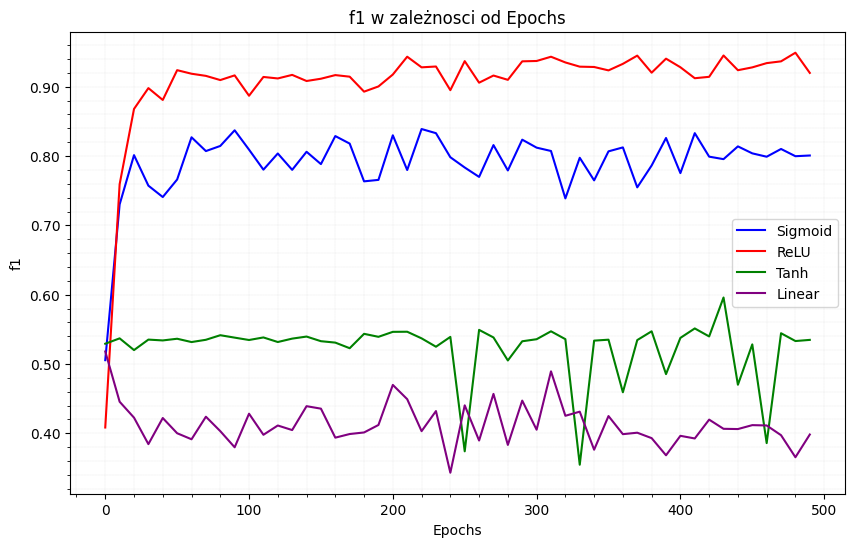

In [123]:
datasets = [f1_1, f1_2, f1_3, f1_4]
labels = ['Sigmoid', 'ReLU', 'Tanh', 'Linear']
colors = ['blue', 'red', 'green', 'purple']

plot_mse(datasets, labels, colors)

'''
mlp5 = MLP(sizes=[2, 10, 10, 3], activation_fn=sigmoid,
                activation_fn_derivative=sigmoid_derivative)  # Example layer setup

# Train the MLP using your training data

f1_5 = mlp5.train(training_data=training_data_rings, epochs=500, learn_rate=0.001, batch_size=20

f1 0.9490614514054228'''
# tak jest do wszystkich bez b
# rings3

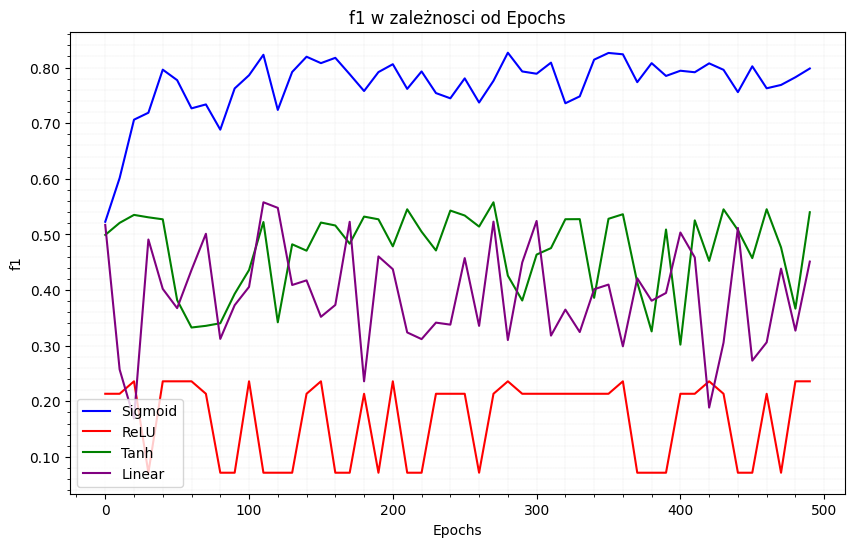

In [124]:
datasets = [f1_1b, f1_2b, f1_3b, f1_4b]
labels = ['Sigmoid', 'ReLU', 'Tanh', 'Linear']
colors = ['blue', 'red', 'green', 'purple']

plot_mse(datasets, labels, colors)
'''
mlp5 = MLP(sizes=[2, 10, 10, 3], activation_fn=sigmoid,
                activation_fn_derivative=sigmoid_derivative)  # Example layer setup

# Train the MLP using your training data

f1_5 = mlp5.train(training_data=training_data_rings, epochs=500, learn_rate=0.01, batch_size=64'''
# tak jest do wszystkich z b
#rings3

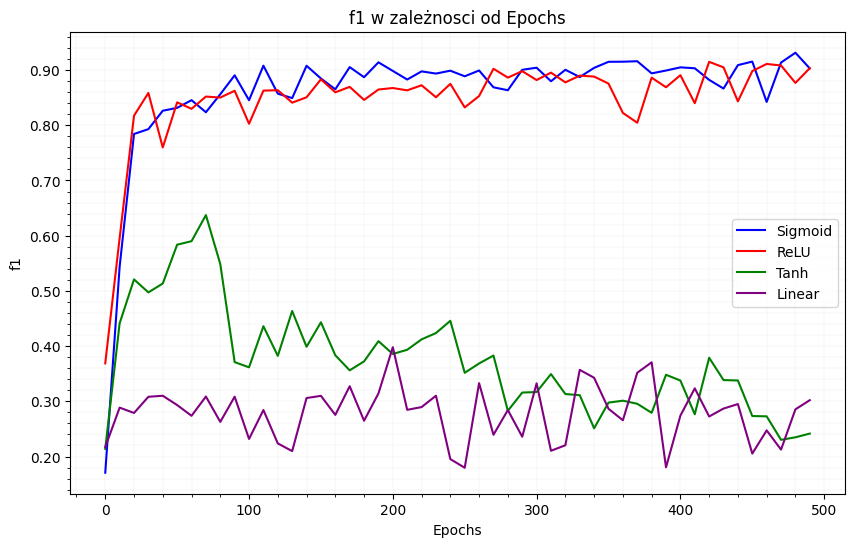

In [125]:
datasets = [f1_5, f1_6, f1_7, f1_8]
labels = ['Sigmoid', 'ReLU', 'Tanh', 'Linear']
colors = ['blue', 'red', 'green', 'purple']

plot_mse(datasets, labels, colors)
'''
mlp5 = MLP(sizes=[2, 10, 10, 5], activation_fn=sigmoid,
                activation_fn_derivative=sigmoid_derivative)  # Example layer setup

# Train the MLP using your training data

f1_5 = mlp5.train(training_data=training_data_rings, epochs=500, learn_rate=0.001, batch_size=20

f1 0.9314167057547685'''
# tak jest do wszystkich bez b
# rings5

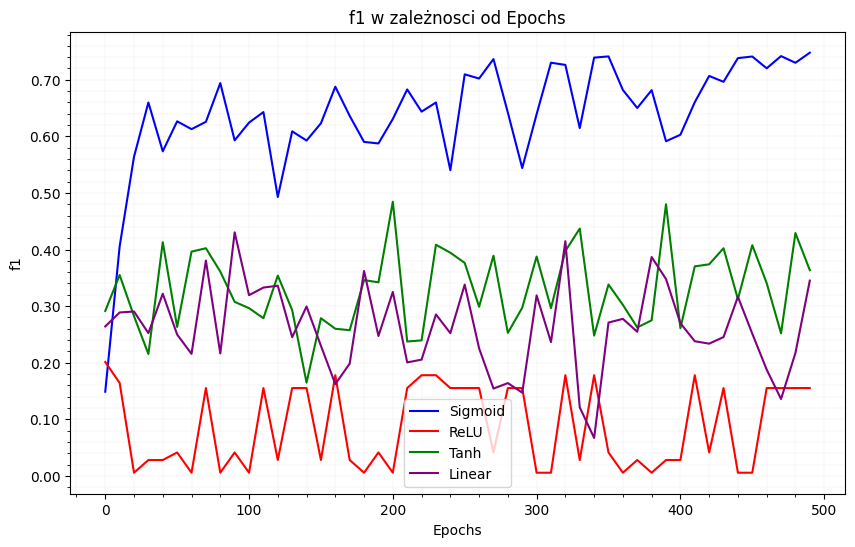

In [126]:
datasets = [f1_5b, f1_6b, f1_7b, f1_8b]
labels = ['Sigmoid', 'ReLU', 'Tanh', 'Linear']
colors = ['blue', 'red', 'green', 'purple']

plot_mse(datasets, labels, colors)
datasets = [f1_1b, f1_2b, f1_3b, f1_4b]
labels = ['Sigmoid', 'ReLU', 'Tanh', 'Linear']
colors = ['blue', 'red', 'green', 'purple']

plot_mse(datasets, labels, colors)
'''
mlp5 = MLP(sizes=[2, 10, 10, 3], activation_fn=sigmoid,
                activation_fn_derivative=sigmoid_derivative)  # Example layer setup

# Train the MLP using your training data

f1_5 = mlp5.train(training_data=training_data_rings, epochs=500, learn_rate=0.01, batch_size=64'''
# tak jest do wszystkich z b
#rings5

In [209]:
# Predict on the test set
# This might involve looping through X_test_scaled and using your model's predict method
predictions_rings_sigmoid = np.argmax(np.array([mlp_rings_sigmoid_2.propagate_forward(x.reshape(-1, 1))[0] for x in X_test_rings]), axis=1)

In [210]:
# Calculate accuracy or other metrics
accuracy_rings = np.mean(predictions_rings_sigmoid == y_test_rings)
print(f'Test accuracy: {accuracy_rings}')


Test accuracy: 0.7565


In [211]:
# Calculate F1 Score
f1_weighted_rings = f1_score(y_test_rings, predictions_rings_sigmoid, average='weighted')

print(f"F1 Score (Weighted): {f1_weighted_rings}")

F1 Score (Weighted): 0.7552693634940021


In [212]:
# Predict on the test set
# This might involve looping through X_test_scaled and using your model's predict method
predictions_rings_relu = np.argmax(np.array([mlp_rings_relu_2.propagate_forward(x.reshape(-1, 1))[0] for x in X_test_rings]), axis=1)

In [213]:
# Calculate accuracy or other metrics
accuracy_rings = np.mean(predictions_rings_relu == y_test_rings)
print(f'Test accuracy: {accuracy_rings}')


Test accuracy: 0.054


In [214]:
# Calculate F1 Score
f1_weighted_rings = f1_score(y_test_rings, predictions_rings_relu, average='weighted')

print(f"F1 Score (Weighted): {f1_weighted_rings}")

F1 Score (Weighted): 0.005533206831119544
